# Interferometric observations of NGC 1068

In [1]:
#3rd party
from __future__ import print_function
from astropy.modeling import models
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import numpy.ma as ma
from copy import copy
import os as os
from importlib import reload

#HyperCAT
import sys
sys.path.append('../hypercat/')
import hypercat as hc
import interferometry as inter
import ioops as io
import ndiminterpolation

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [228]:
def plot_inter(sky,fftscale,u,v,corrflux,BL):
    ### Figures
    fig, (ax1,ax2,ax3,ax4) = plt.subplots(1,4,figsize=(16,3))

    #Image
    xx1 = np.linspace(sky.npix//2*(-1.*sky.pixelscale.value),\
                  sky.npix//2*(sky.pixelscale.value),\
                  sky.npix)

    aa = np.log10(sky.data.T.value*1000.+1E-6)
    levels = np.linspace(np.min(aa[aa>-6]),np.max(aa),21)
    cbar1 = ax1.contourf(xx1,xx1,aa,levels=levels)
    plt.colorbar(cbar1,label='log(Flux [mJy])',ax=ax1)
    ax1.set_ylim([np.min(xx1),np.max(xx1)])
    ax1.set_xlim([np.min(xx1),np.max(xx1)])
    ax1.set_xlabel('Offset (mas)')
    ax1.set_ylabel('Offset (mas)')

    #Image in FFT space
    pixscale_masmet = fftscale/sky.pixelscale.value
    xx2 = np.linspace(sky.npix//2*(-fftscale),\
                  sky.npix//2*(fftscale),\
                  sky.npix)
    cbar = ax2.contourf(xx2,xx2,np.log10(np.abs(ori_fft)/np.max(np.abs(ori_fft))),51)
    plt.colorbar(cbar,label='Normalized flux',ax=ax2)
    ax2.set_ylim([-150,150])
    ax2.set_xlim([150,-150])
    ax2.set_xlabel('u (m)')
    ax2.set_ylabel('v (m)')

    #uv plave vs. correlated flux
    cbar=ax3.scatter(u,v,c = np.log10(corrflux),s=50,linewidths=0)
    plt.colorbar(cbar,label='$\log$ (F$_{corr}$)',ax=ax3)
    ax3.set_ylim([-150,150])
    ax3.set_xlim([150,-150])
    ax3.set_ylabel('v [m]',fontsize=10)
    ax3.set_xlabel('u [m]',fontsize=10)
    ax3.axvline(0,linestyle='--',color='black',linewidth=0.5)
    ax3.axhline(0,linestyle='--',color='black',linewidth=0.5)

    #Correlated flux vs. Baseline vs. PA
    cbar = ax4.scatter(BL,corrflux,c = Phi,s=50,linewidths=0)
    #plt.plot(0,sky.data.value.sum(),'x',color='black')
    plt.colorbar(cbar,label='PA ($^{\circ}$)',ax=ax4)
    ax4.set_ylim([0,corrflux.max()*1.2])
    ax4.set_xlim([-5,140])
    ax4.set_ylabel('F$_{corr}$ [Jy]',fontsize=10)
    ax4.set_xlabel('Baseline [m]',fontsize=10)

    fig.tight_layout()

In [2]:
# Load a sub-cube into RAM
hypercube = '/Volumes/Seagate Backup Plus Drive/hypercat/hypercat_20170827.hdf5'
subcube = '/Users/elopezro/Documents/Projects/NGC1068_SOFIA/Science/HyperCAT/subcube_ngc1068.json'
cube = hc.ModelCube(hdffile=hypercube,hypercube='imgdata',subcube_selection=subcube)

Opening HDF5 file: /Volumes/Seagate Backup Plus Drive/hypercat/hypercat_20170827.hdf5 
Loading sampling parameters.
Closing HDF5 file.
Loading objects from file /Users/elopezro/Documents/Projects/NGC1068_SOFIA/Science/HyperCAT/subcube_ngc1068.json.
Loading hyperslab [shape: (3,2,3,3,2,4,19,121,241)] from hypercube 'imgdata' [shape: (5,10,16,12,5,7,19,121,241)] to RAM (913.06 MB required) ...
Done.
Squeezing all dim-1 axes...
Instantiating n-dim interpolation object ...
Done.
Inspect the loaded hypercube with .print_sampling()

-------------------------------------------------------
Parameter  Range                Nvalues  Sampled values
-------------------------------------------------------
 sig*    [ 15.000 -  45.000]  (  3)    15.000, 30.000, 45.000
   i*    [ 70.000 -  80.000]  (  2)    70.000, 80.000
   Y*    [ 13.000 -  19.000]  (  3)    13.000, 18.000, 19.000
   N*    [  4.000 -  11.000]  (  3)     4.000,  5.000, 11.000
   q*    [  0.000 -   0.500]  (  2)     0.000,  0.500
  tv*

Rotated image (see self.data) by 42.0 deg in direction 'NE'.
Coordinates for source 'ngc1068' resolved. WCS created.
Pixel scale in FFT image is:  6.0567863912981394  m (Baseline) per pixel


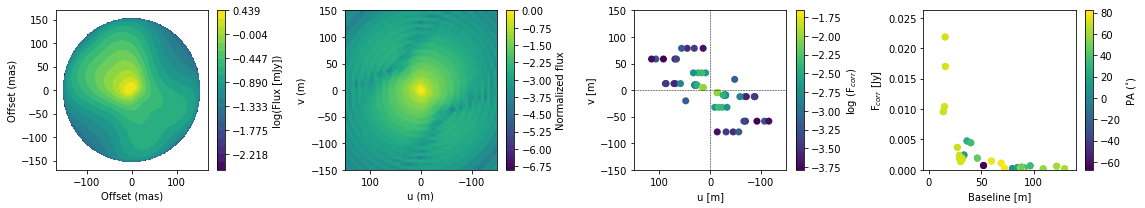

In [235]:
#NGC 1068 physical parameters
lum  = '1.65e45 erg/s'
dis  = '12.5 Mpc'
name = 'ngc1068'
pa   = '42 deg'

#Make a source
ngc1068 = hc.Source(cube,luminosity=lum,distance=dis,objectname=name,pa=pa) 

#Select a clumpy torus image and wavelength. Assuming a flux density of 10105 mJy at 10 microns.
#clumpy models
wave = 10.0

sig = 43.
Y   = 18.
N   = 4.
q   = 0.08
tv  = 70.
inc   = 75.
flux = '10.0 Jy'

vec = (sig,inc,Y,N,q,tv,wave)
sky = ngc1068(vec,total_flux_density=flux,getwcs=True)

#interferometric observatoona from Burtscher+13
DIR = '/Users/elopezro/Documents/GitHub/agn-imaging/data/oifits_Burtscher13/'
uvfilename = DIR+'NGC1068.oifits'

reload(inter)
#Create 2D FFT of clumpy torus image
ori_fft = inter.ima2fft(sky)
#Obtain pixel scale
fftscale = inter.fft_pxscale(sky)
#Obtain uv points
u,v = inter.uvload(uvfilename)
#Obtain correlated flux
corrflux, BL, Phi = inter.correlatedflux(ori_fft,u,v)

plot_inter(sky,fftscale,u,v,corrflux,BL)

# Example with Gaussians

In [216]:
def plot_inter(sky,gauss,gauss_fft,fftscale,u,v,corrflux,BL,Gaussian=True):
    ### Figures
    fig, (ax1,ax2,ax3,ax4) = plt.subplots(1,4,figsize=(16,3))

    #Image
    xx1 = np.linspace(sky.npix//2*(-1.*sky.pixelscale.value),\
                  sky.npix//2*(sky.pixelscale.value),\
                  sky.npix)

    aa = np.log10(gauss)
    levels = np.linspace(np.min(aa[aa>-6]),np.max(aa),21)
    cbar1 = ax1.contourf(xx1,xx1,aa,levels=levels)
    plt.colorbar(cbar1,label='log(Flux [mJy])',ax=ax1)
    ax1.set_ylim([np.min(xx1),np.max(xx1)])
    ax1.set_xlim([np.min(xx1),np.max(xx1)])
    ax1.set_xlabel('Offset (mas)')
    ax1.set_ylabel('Offset (mas)')

    #Image in FFT space
    pixscale_masmet = fftscale/sky.pixelscale.value
    xx2 = np.linspace(sky.npix//2*(-fftscale),\
                  sky.npix//2*(fftscale),\
                  sky.npix)
    if Gaussian == True:
        cbar = ax2.contourf(xx2,xx2,np.abs(gauss_fft)/np.max(np.abs(gauss_fft)),101)
        label = 'Normalized flux'
    else:
        cbar = ax2.contourf(xx2,xx2,np.log10(np.abs(gauss_fft)/np.max(np.abs(gauss_fft))),101)
        label = 'log(Normalized flux)'
    plt.colorbar(cbar,label=label,ax=ax2)
    ax2.set_ylim([-150,150])
    ax2.set_xlim([150,-150])
    ax2.set_xlabel('u (m)')
    ax2.set_ylabel('v (m)')

    #uv plave vs. correlated flux
    cbar=ax3.scatter(u,v,c = np.log10(corrflux),s=50,linewidths=0,vmin=np.min(np.log10(corrflux)),vmax=0)
    plt.colorbar(cbar,label='$\log$ (Normalized Flux)',ax=ax3)
    ax3.set_ylim([-150,150])
    ax3.set_xlim([150,-150])
    ax3.set_ylabel('v [m]',fontsize=10)
    ax3.set_xlabel('u [m]',fontsize=10)
    ax3.axvline(0,linestyle='--',color='black',linewidth=0.5)
    ax3.axhline(0,linestyle='--',color='black',linewidth=0.5)

    #Correlated flux vs. Baseline vs. PA
    cbar = ax4.scatter(BL,corrflux,c = Phi,s=50,linewidths=0)
    plt.plot(0,gauss.sum(),'x',color='black')
    plt.colorbar(cbar,label='PA ($^{\circ}$)',ax=ax4)
    ax4.set_ylim([0,gauss.sum()*1.2])
    ax4.set_xlim([-5,140])
    ax4.set_ylabel('F$_{corr}$ [Jy]',fontsize=10)
    ax4.set_xlabel('Baseline [m]',fontsize=10)

    fig.tight_layout()

In [217]:
def gauss(g,sky,uvfilename,Gaussian=True):
    #Use same grid as model image
    xx = np.linspace(-sky.npix//2,sky.npix//2,sky.npix)
    x,y = np.meshgrid(xx,xx)
    if Gaussian == True:
        gg = g(x,y)/np.sum(g(x,y)) #normalize Gaussian
    else:
        gg = sky.data.T.value


    #Create FFT 2D image
    g_fft = inter.ima2fft(gg)
    #Obtain pixel scale
    fftscale = inter.fft_pxscale(sky)
    #Obtain uv points
    u,v = inter.uvload(uvfilename)
    #Obtain correlated flux
    ima_fft = np.abs(g_fft)   

    #total flux
    f_t = np.abs(np.fft.fft2(gg)[0][0])

    #correlated flux
    xx  = np.arange(ima_fft.shape[0])
    ip = ndiminterpolation.NdimInterpolation(ima_fft,[xx,xx])
    uu = u + ima_fft.shape[0]//2
    vv = v + ima_fft.shape[0]//2
    corrflux = ip(np.dstack((uu,vv)))

    #baseline and PA
    BL = np.sqrt(u**2+v**2)
    Phi = np.rad2deg(np.arctan(u/v))

    plot_inter(sky,gg+1E-9,g_fft,fftscale,u,v,corrflux,BL,Gaussian)

Pixel scale in FFT image is:  0.09690858226077854  m (Baseline) per pixel
Pixel scale in FFT image is:  0.09690858226077854  m (Baseline) per pixel
Pixel scale in FFT image is:  0.09690858226077854  m (Baseline) per pixel
Pixel scale in FFT image is:  0.09690858226077854  m (Baseline) per pixel


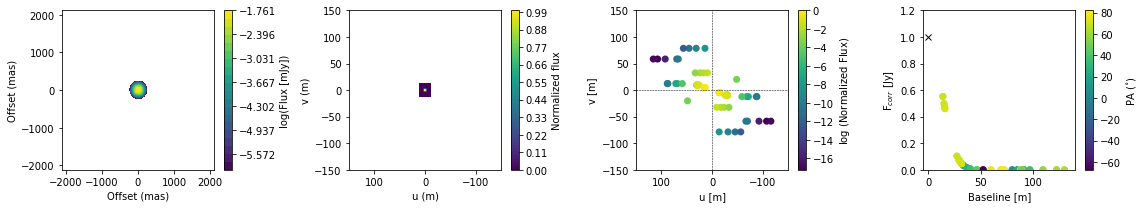

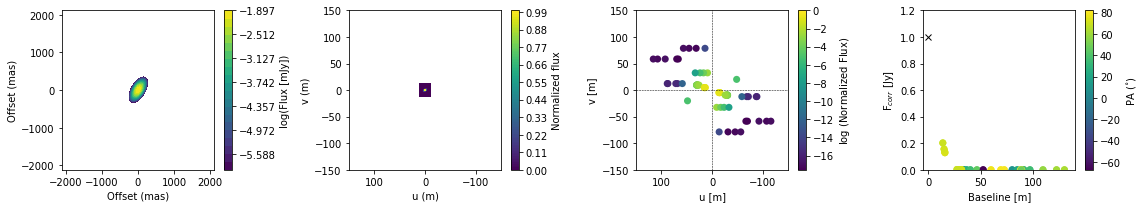

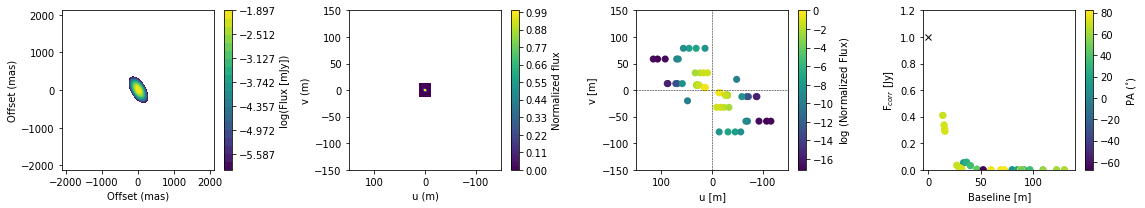

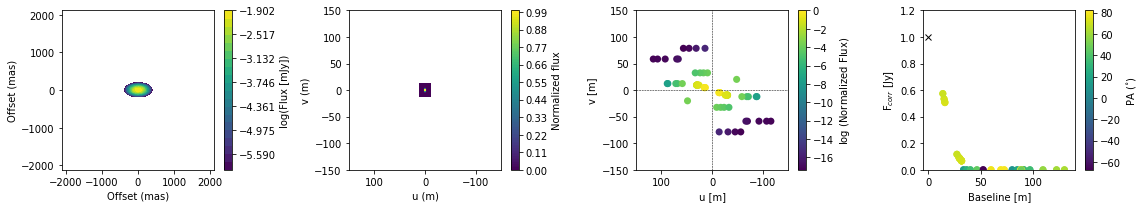

In [218]:
#Create Gaussian
g0  = models.Gaussian2D(amplitude=1, x_mean=0, y_mean=0, \
                       x_stddev=3, y_stddev=3, \
                       theta=0)

g1  = models.Gaussian2D(amplitude=1, x_mean=0, y_mean=0, \
                       x_stddev=5, y_stddev=2.5, \
                       theta=45)

g2  = models.Gaussian2D(amplitude=1, x_mean=0, y_mean=0, \
                       x_stddev=5, y_stddev=2.5, \
                       theta=-45)

g4  = models.Gaussian2D(amplitude=1, x_mean=0, y_mean=0, \
                       x_stddev=5, y_stddev=2.5, \
                       theta=0.)


gauss(g0,sky,uvfilename,Gaussian=True)
gauss(g1,sky,uvfilename,Gaussian=True)
gauss(g2,sky,uvfilename,Gaussian=True)
gauss(g4,sky,uvfilename,Gaussian=True)

Pixel scale in FFT image is:  0.09690858226077854  m (Baseline) per pixel


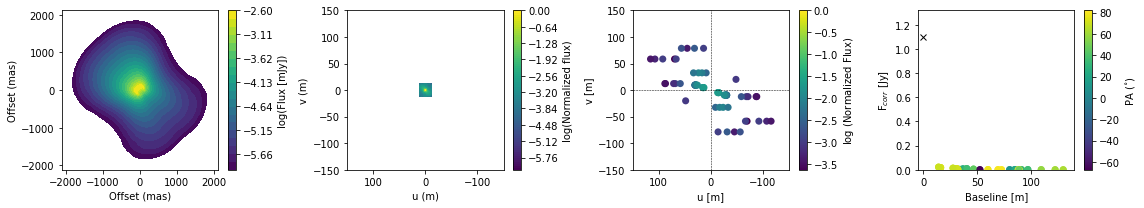

In [220]:
gauss(g,sky,uvfilename,Gaussian=False)